# Forecast retail sales for retail sores and departments using features such as store size and type, 

In [3]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

## Import dataset in to Dataframes

In [4]:
retail_data_path ='C:/Users/Nimish/Documents/ML Projects/Retail Kaggle/Data Set'
file_list = os.listdir(retail_data_path)
file_list

['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']

In [6]:
features_df = pd.read_csv(retail_data_path + '/' + file_list[0])
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
sales_df = pd.read_csv(retail_data_path + '/' + file_list[1])
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [8]:
stores_df = pd.read_csv(retail_data_path + '/' + file_list[2])
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Data Pre-processing

In [9]:
merge1 = pd.merge(stores_df, sales_df, on='Store')
merge1 = merge1.drop('IsHoliday', axis = 1)
all_merge = pd.merge(merge1, features_df, on=['Store','Date'])
all_merge = all_merge.fillna(0)
all_merge

,Store,Type,Size,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,A,151315,1,05/02/2010,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False
1,1,A,151315,2,05/02/2010,50605.27,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False
2,1,A,151315,3,05/02/2010,13740.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False
3,1,A,151315,4,05/02/2010,39954.04,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False
4,1,A,151315,5,05/02/2010,32229.38,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,B,118221,93,26/10/2012,2487.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False
421566,45,B,118221,94,26/10/2012,5203.31,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False
421567,45,B,118221,95,26/10/2012,56017.47,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False
421568,45,B,118221,97,26/10/2012,6817.48,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False


In [10]:
# Encode Categorical Variable Type with label encoder
le = LabelEncoder()
all_merge['Type'] = le.fit_transform(all_merge['Type'])

In [11]:
features = all_merge[["Store", "Dept","Temperature" ,"MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5", "Fuel_Price" , "CPI" , "Unemployment" , "IsHoliday" , "Type" , "Size"]]
target = all_merge["Weekly_Sales"] 

In [12]:
# Convert int64 columns to int8
#int64_columns = features.select_dtypes(include='int64').columns
#features[int64_columns] = features[int64_columns].astype('int8')

# Convert float64 columns to float16
#float64_columns = features.select_dtypes(include='float64').columns
#features[float64_columns] = features[float64_columns].astype('float16')

features.dtypes

Store             int64
Dept              int64
Temperature     float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type              int32
Size              int64
dtype: object

In [13]:
# Train on lightgbm model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert the data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Record the start time
start_time = time.time()


# Set parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'bagging_fraction': 0.9,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_round': 10,
    'lambda_l1': 0.1,
    'lambda_l2':0.2
}

# Train the LightGBM model
num_round = 3000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Compute and print RMSE and R2 score
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'Run Time: {runtime}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 14
[LightGBM] [Info] Start training from score 15955.149364
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 5146.8
RMSE: 5146.800552773525
R2 Score: 0.9496132937769779
Run Time: 37.235533237457275


<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='Gain', ylabel='Features'>

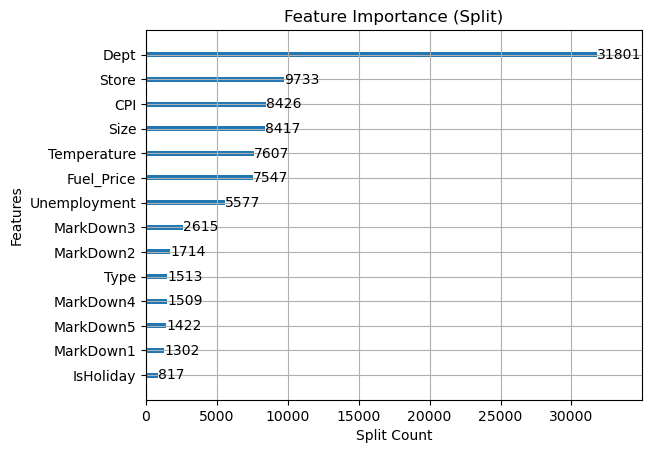

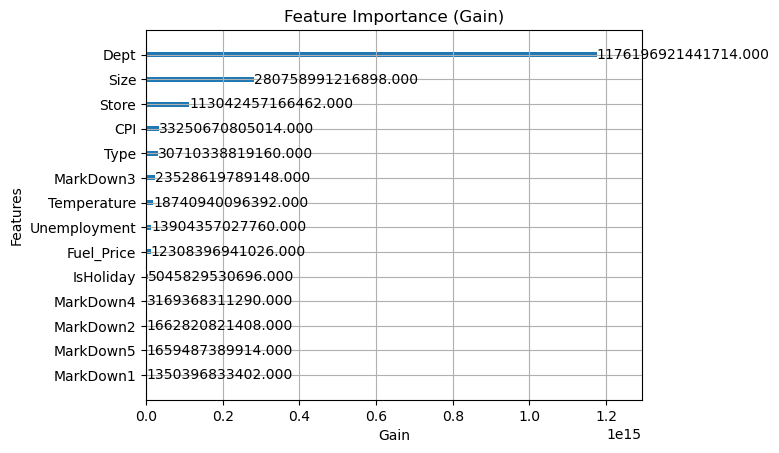

In [47]:
lgb.plot_importance(bst, importance_type='split', title='Feature Importance (Split)', xlabel='Split Count')
lgb.plot_importance(bst, importance_type='gain', title='Feature Importance (Gain)', xlabel='Gain')

## Sales Forecast using Catboost

In [59]:
# Set parameters for the CatBoost model
params = {
    'iterations': 3000,
    'learning_rate': 0.05,
    'depth': 10,
    'loss_function': 'RMSE',
    'verbose': 100
}

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(**params)

start_time = time.time()

# Train the CatBoost model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Compute and print RMSE and R2 score
rmse_cat = mean_squared_error(y_test, y_pred, squared=False)
r2_cat = r2_score(y_test, y_pred)

print(f'RMSE: {rmse_cat}')
print(f'R2 Score: {r2_cat}')
print(f'Run Time: {runtime}')

0:	learn: 22114.4640447	test: 22391.5806782	best: 22391.5806782 (0)	total: 196ms	remaining: 9m 46s
100:	learn: 10138.8997716	test: 10589.1490380	best: 10589.1490380 (100)	total: 13.6s	remaining: 6m 30s
200:	learn: 8458.4082373	test: 8963.3222890	best: 8963.3222890 (200)	total: 27s	remaining: 6m 15s
300:	learn: 7539.9202961	test: 8082.1044813	best: 8082.1044813 (300)	total: 40.5s	remaining: 6m 3s
400:	learn: 6917.8075769	test: 7511.6049622	best: 7511.6049622 (400)	total: 54s	remaining: 5m 49s
500:	learn: 6468.3151702	test: 7087.3523105	best: 7087.3523105 (500)	total: 1m 7s	remaining: 5m 38s
600:	learn: 6157.7931640	test: 6799.8291411	best: 6799.8291411 (600)	total: 1m 21s	remaining: 5m 26s
700:	learn: 5899.1463501	test: 6572.9801941	best: 6572.9801941 (700)	total: 1m 36s	remaining: 5m 15s
800:	learn: 5681.1885851	test: 6386.0867989	best: 6386.0867989 (800)	total: 1m 52s	remaining: 5m 9s
900:	learn: 5500.7786197	test: 6224.6712806	best: 6224.6712806 (900)	total: 2m 7s	remaining: 4m 56s
1